# Web Scraping 

Realtor.com es una plataforma de bienes raíces en línea que facilita la compra, venta, y alquiler de propiedades en Estados Unidos. Operada por Move, Inc. y asociada con la National Association of Realtors, Realtor.com se destaca por su amplia base de datos y recursos informativos para el mercado inmobiliario.

El objetivo es realizar Web Scrpaing de las propiedades vendidas de California.

### 1. Importamos las librerias que vamos a utilizar para realizar el web scarping

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Web Scraping
# ==============================================================================
from selenium import webdriver
import requests
import os
from bs4 import BeautifulSoup
import time
from selenium.webdriver.chrome.options import Options

### 2. Configuramos el navegador

Establecemos un tiempo de espera implícito de 10 segundos.

In [479]:
options = Options()
options.add_argument("--auto-open-devtools-for-tabs")  # Automatically open DevTools

driver = webdriver.Chrome(options=options)
driver.implicitly_wait(10)

### 3. Creamos la función para guardar la imágen principal de cada propiedad.

In [480]:
# Función para guardar imágenes
def save_image(image_url, filename, folder_path='zillow_images'):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        with open(os.path.join(folder_path, filename), 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)

### 4. Creamos un DataFrame formato CSV. 

Donde guardaremos la información de las propiedades a partir de la lista de diccionarios que vamos a crear.

In [22]:
# Crear un DataFrame a partir de la lista de diccionarios
df = pd.read_csv('zillow_listings.csv')
df.head()

,Address,Price,Beds,Baths,Square Feet,Date Sold
0,"2200 Sacramento St APT 206, San Francisco, CA ...",$1.72M,2.0,2.0,969.0,2024-02-16
1,"114 10th Ave, San Francisco, CA 94118",$1.85M,3.0,2.0,2181.0,2024-02-16
2,"1982 44th Ave, San Francisco, CA 94116",$1.45M,3.0,2.0,1150.0,2024-02-16
3,"2731 41st Ave, San Francisco, CA 94116",$1.31M,2.0,1.0,1012.0,2024-02-16
4,"216 Dorland St, San Francisco, CA 94114",$1.36M,2.0,2.0,1132.0,2024-02-16


In [482]:
# Aquí definimos properties_data como una lista vacía
properties_data = []

image_folder_path = 'zillow_images'

### 5. Creamos la función para comenzar con el web scraping

In [483]:
def extract_bold_items(list_item):
    try:
        if list_item:
            list_item_text_container = list_item.find('b')
            text = list_item_text_container.text if list_item_text_container != None else None
            if (text == '--' or text == None):
                return None
            return float(text.replace(',', ''))
    except Exception as e:
        print(f"Error: {e}")
        return None

def extract_data_from_url(url):
    max_scroll_distance = 9000
    current_scroll_distance = 500

    driver.get(url)
    time.sleep(20)

    while max_scroll_distance > 0:
        driver.execute_script(f"window.scrollTo({{ top: {current_scroll_distance}, behavior: 'smooth' }});")
        current_scroll_distance += 500
        max_scroll_distance -= 500
        time.sleep(2)
        
    time.sleep(10)
    driver.execute_script(f"window.scrollTo({{ top: 0, behavior: 'smooth' }});")

    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    listings = soup.find_all('li', class_='StyledListCardWrapper-srp__sc-wtsrtn-0')

    for i, listing in enumerate(listings):
        title = listing.find("title")
        is_loading = title.text if title else None
        if (is_loading == "Loading"):
            print(url + f" {i} was loading")
            continue

        # Extraer la información de cada propiedad
        try:
            address = listing.find(attrs={"data-test": "property-card-addr"}).text
            price = listing.find(attrs={"data-test": "property-card-price"}).text
            date_sold = listing.find('span', class_='StyledPropertyCardBadge-c11n-8-84-3__sc-6gojrl-0').text.replace('Sold ', '')
            date_sold = pd.to_datetime(date_sold)
            details_container = listing.find('ul', class_='StyledPropertyCardHomeDetailsList-c11n-8-84-3__sc-1xvdaej-0')
            details = details_container.find_all('li')
            details_length = len(details)
            beds = extract_bold_items(details[0]) if details_length > 0 else None
            baths = extract_bold_items(details[1]) if details_length > 1 else None
            sqft = extract_bold_items(details[2]) if details_length > 2 else None

            # # Añadir la fila a la lista de diccionarios
            properties_data.append({
                'Address': address,
                'Price': price,
                'Beds': beds,
                'Baths': baths,
                'Square Feet': sqft,
                'Date Sold': date_sold
            })

            # # Obtener URL de la imagen y guardarla
            image_element = listing.find('img')
            image_url = image_element.get('src')
            filename = f"{address.replace(' ', '_').replace(',', '').replace('|', '')}.jpg"
            save_image(image_url, filename, image_folder_path)
        except Exception as e:
            print(f"Error: {e} - {i} - {url}\n\n")

Tenemos que ejecutar este cuaderno varias veces para descargar cada página de listados, porque zillow bloquea los intentos múltiples.

In [484]:
# extract_data_from_url('https://www.zillow.com/ca/sold/')
# extract_data_from_url('https://www.zillow.com/ca/sold/2_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/3_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/4_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/5_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/6_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/7_p/')
# extract_data_from_url('https://www.zillow.com/ca/sold/8_p/')
#extract_data_from_url('https://www.zillow.com/ca/sold/9_p/')

https://www.zillow.com/ca/sold/9_p/ 2 was loading
Error: 'NoneType' object has no attribute 'text' - 12 - https://www.zillow.com/ca/sold/9_p/




In [485]:
# Cerrar el navegador
driver.quit()

In [486]:
print(properties_data)

[{'Address': '810 W Naomi Ave UNIT 6, Arcadia, CA 91007', 'Price': '$798,000', 'Beds': 3.0, 'Baths': 2.0, 'Square Feet': 1600.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '709 Coronado Ter, Los Angeles, CA 90026', 'Price': '$1.33M', 'Beds': 3.0, 'Baths': 3.0, 'Square Feet': 1614.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '726 N Las Palmas Ave, Los Angeles, CA 90038', 'Price': '$2.00M', 'Beds': 2.0, 'Baths': 2.0, 'Square Feet': 1765.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '6830 De Longpre Ave, Los Angeles, CA 90028', 'Price': '$940,000', 'Beds': 2.0, 'Baths': 2.0, 'Square Feet': 910.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '6700 Hillpark Dr APT 203, Los Angeles, CA 90068', 'Price': '$645,000', 'Beds': 2.0, 'Baths': 2.0, 'Square Feet': 1154.0, 'Date Sold': Timestamp('2024-02-16 00:00:00')}, {'Address': '7048 Macapa Dr, Los Angeles, CA 90068', 'Price': '$4.00M', 'Beds': 3.0, 'Baths': 3.0, 'Square Feet': 294

In [487]:
new_df = pd.DataFrame(properties_data)
df = pd.concat([df, new_df])
df.head()

,Address,Price,Beds,Baths,Square Feet,Date Sold
0,"2200 Sacramento St APT 206, San Francisco, CA ...",$1.72M,2.0,2.0,969.0,2024-02-16
1,"114 10th Ave, San Francisco, CA 94118",$1.85M,3.0,2.0,2181.0,2024-02-16
2,"1982 44th Ave, San Francisco, CA 94116",$1.45M,3.0,2.0,1150.0,2024-02-16
3,"2731 41st Ave, San Francisco, CA 94116",$1.31M,2.0,1.0,1012.0,2024-02-16
4,"216 Dorland St, San Francisco, CA 94114",$1.36M,2.0,2.0,1132.0,2024-02-16


In [488]:
# Guardar el DataFrame en un archivo CSV
df.to_csv('zillow_listings.csv', index=False)

In [489]:
df.shape

(324, 6)

# EDA - listing web scraping Zillow

### 1. Cargamos el dataset 

In [2]:
df = pd.read_csv('zillow_listings.csv', encoding='utf-8', sep=',')

In [3]:
df.head()

,Address,Price,Beds,Baths,Square Feet,Date Sold
0,"2200 Sacramento St APT 206, San Francisco, CA ...",$1.72M,2.0,2.0,969.0,2024-02-16
1,"114 10th Ave, San Francisco, CA 94118",$1.85M,3.0,2.0,2181.0,2024-02-16
2,"1982 44th Ave, San Francisco, CA 94116",$1.45M,3.0,2.0,1150.0,2024-02-16
3,"2731 41st Ave, San Francisco, CA 94116",$1.31M,2.0,1.0,1012.0,2024-02-16
4,"216 Dorland St, San Francisco, CA 94114",$1.36M,2.0,2.0,1132.0,2024-02-16


In [4]:
df.tail()

,Address,Price,Beds,Baths,Square Feet,Date Sold
319,"2232 Daladier Dr, Rancho Palos Verdes, CA 90275",$1.68M,4.0,3.0,2948.0,2024-02-16 00:00:00
320,"27989 Beechgate Dr, Rancho Palos Verdes, CA 90275",$1.55M,4.0,3.0,2390.0,2024-02-16 00:00:00
321,"13218 La Jolla Cir UNIT C, La Mirada, CA 90638","$675,000",3.0,2.0,1271.0,2024-02-16 00:00:00
322,"14348 Flomar Dr, Whittier, CA 90603","$745,000",2.0,2.0,1479.0,2024-02-16 00:00:00
323,"816 Reed Dr, Claremont, CA 91711","$900,000",3.0,2.0,1610.0,2024-02-16 00:00:00


### Contamos el número de valores únicos de cada columna.

In [5]:
df.nunique()

Address        324
Price          233
Beds             7
Baths            8
Square Feet    287
Date Sold        2
dtype: int64

### Comprobmaos los valores únicos de unas columnas concretas.

In [6]:
df['Date Sold'].unique()

array(['2024-02-16', '2024-02-16 00:00:00'], dtype=object)

In [7]:
df['Baths'].unique()

array([2. , 1. , 4. , 3. , 7. , nan, 5. , 6. , 2.5])

In [8]:
df['Beds'].unique()

array([ 2.,  3.,  5.,  4.,  6., nan,  1.,  8.])

### Comprobamos el tamaño del dataset

In [9]:
df.shape

(324, 6)

### Comprobamos si tenemos valroes duplicados.

In [10]:
df.duplicated().sum()

0

### Comprobamos el tipo de valores que tiene cada una de las columnas.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Address      324 non-null    object 
 1   Price        324 non-null    object 
 2   Beds         319 non-null    float64
 3   Baths        319 non-null    float64
 4   Square Feet  320 non-null    float64
 5   Date Sold    324 non-null    object 
dtypes: float64(3), object(3)
memory usage: 15.3+ KB


### Comprobamos si existen valores NaN en cada columna.

In [12]:
df.isnull().sum()

Address        0
Price          0
Beds           5
Baths          5
Square Feet    4
Date Sold      0
dtype: int64

### Observaciones

Observamos que las 324 viviendas se vendieron el mismo día 16/02/2024. El día que realicé el scraping fué el 17/02. No tenemos datos duplicados.

· La columna **'Date Sold'** está en formato object y hay algunas filas que tienen la fecha y la hora.  
· La columna **'price'** está en formato object, y contiene el simbolo $ y M.  
· La columna **'Baths'** está en formato float, lo mantenemos porque comprobamos que alguna fila tiene 2.5 baños. Tiene 5 valores nulos.
· La columna **'Beds'** está en formato float, la podemos convertir en int. Tiene 5 valores nulos.  
· La columna **'Square feet'** tiene 4 volores nulos.
· La columna **'Adress'** está en formato object, para facilitar el análisis es posible que separemos la información por población a través del código postal y población.

### Analisis estadístico

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Beds,319.0,3.197492,0.978637,1.0,3.00,3.0,4.00,8.0
Baths,319.0,2.474922,0.930441,1.0,2.00,2.0,3.00,7.0
Square Feet,320.0,1846.637500,809.449842,572.0,1271.75,1689.0,2182.25,5173.0


# Limpieza de Datos y Transformación de Datos

### Extracción de componentes 'Address'

Vamos a empezar por la columna **Adress** vamos a separar y crear nuevas columnas con la dirección, población, codigo postal y estado. Después eliminaremos el estado ya que solo estamos trabajando con datos de California.

In [14]:
# Separamos la dirección en nuevas columnas por cada coma
df[['Street', 'City', 'State_Zip']] = df['Address'].str.split(',', expand=True)

# Separamos el estado y el código postal en dos columnas distintas
df[['State', 'Zip']] = df['State_Zip'].str.strip().str.split(' ', expand=True)

# Eliminamos las columnas 'State_Zip', 'Adress' y State
df.drop(columns=['State_Zip','Address','State'], inplace=True)

df

,Price,Beds,Baths,Square Feet,Date Sold,Street,City,Zip
0,$1.72M,2.0,2.0,969.0,2024-02-16,2200 Sacramento St APT 206,San Francisco,94115
1,$1.85M,3.0,2.0,2181.0,2024-02-16,114 10th Ave,San Francisco,94118
2,$1.45M,3.0,2.0,1150.0,2024-02-16,1982 44th Ave,San Francisco,94116
3,$1.31M,2.0,1.0,1012.0,2024-02-16,2731 41st Ave,San Francisco,94116
4,$1.36M,2.0,2.0,1132.0,2024-02-16,216 Dorland St,San Francisco,94114
...,...,...,...,...,...,...,...,...
319,$1.68M,4.0,3.0,2948.0,2024-02-16 00:00:00,2232 Daladier Dr,Rancho Palos Verdes,90275
320,$1.55M,4.0,3.0,2390.0,2024-02-16 00:00:00,27989 Beechgate Dr,Rancho Palos Verdes,90275
321,"$675,000",3.0,2.0,1271.0,2024-02-16 00:00:00,13218 La Jolla Cir UNIT C,La Mirada,90638
322,"$745,000",2.0,2.0,1479.0,2024-02-16 00:00:00,14348 Flomar Dr,Whittier,90603


### 'Price'

Para transformar la columna del precio y manejar ambos formatos (por ejemplo, "$ 1.72M" y "$ 675,000"), primero eliminaremos el carácter '$', luego convertiremos los valores que terminan en 'M' a millones (multiplicándolos por 1,000,000) y finalmente eliminaremos las comas

In [15]:
# Eliminamos el carácter '$' y las comas de la columna 'Price'
df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '')

# Convertimos los valores que terminan en 'M' a su equivalente numérico en millones
# Primero, identificamos cuáles terminan en 'M' y luego convertimos
df['Price'] = df['Price'].apply(lambda x: float(x.rstrip('M')) * 1e6 if x.endswith('M') else float(x))

In [16]:
df

,Price,Beds,Baths,Square Feet,Date Sold,Street,City,Zip
0,1720000.0,2.0,2.0,969.0,2024-02-16,2200 Sacramento St APT 206,San Francisco,94115
1,1850000.0,3.0,2.0,2181.0,2024-02-16,114 10th Ave,San Francisco,94118
2,1450000.0,3.0,2.0,1150.0,2024-02-16,1982 44th Ave,San Francisco,94116
3,1310000.0,2.0,1.0,1012.0,2024-02-16,2731 41st Ave,San Francisco,94116
4,1360000.0,2.0,2.0,1132.0,2024-02-16,216 Dorland St,San Francisco,94114
...,...,...,...,...,...,...,...,...
319,1680000.0,4.0,3.0,2948.0,2024-02-16 00:00:00,2232 Daladier Dr,Rancho Palos Verdes,90275
320,1550000.0,4.0,3.0,2390.0,2024-02-16 00:00:00,27989 Beechgate Dr,Rancho Palos Verdes,90275
321,675000.0,3.0,2.0,1271.0,2024-02-16 00:00:00,13218 La Jolla Cir UNIT C,La Mirada,90638
322,745000.0,2.0,2.0,1479.0,2024-02-16 00:00:00,14348 Flomar Dr,Whittier,90603


### Imputar valores NaN de las variables 'Baths', 'Beds' y Square Feet

Antes de transformar las variables 'Baths', 'Beds' y Square Feet vamos a imputar los valores NaN. No vamos a eliminar columnas porque nuestro dataset es pequeño, lo que aplicaremos Media o Mediana al tener datos numéricos, imputar con la media o la mediana de la columna puede ser un enfoque rápido y efectivo, especialmente si la distribución de los datos es relativamente uniforme.

In [17]:
# Imputación con la media para 'Beds'y'Baths' 
df['Beds'] = df['Beds'].fillna(df['Beds'].mean())
df['Baths'] = df['Baths'].fillna(df['Baths'].mean())

In [18]:
# Imputación con la mediana para 'Square Feet'
df['Square Feet'] = df['Square Feet'].fillna(df['Square Feet'].median())

In [19]:
# Comprobamos que no quede ningún valor NaN
df.isnull().sum()

Price          0
Beds           0
Baths          0
Square Feet    0
Date Sold      0
Street         0
City           0
Zip            0
dtype: int64

### 'Baths'

Nos encontramos que en los valores de Baths, existen 'medios' que corresponden a aseos, no medios baños, lo que realizaremos a continuación, es crear una nueva columna con el número de aseos, y convertiremos la columna Beds, Baths y toilets en int (números eneteros).

### 1. Crear una nueva columna 'Toilets' basada en si 'Baths' tiene un valor decimal. (0.5)

In [20]:
# El número de aseos será el decimal multiplicado por 2 (asumiendo que .5 representa un aseo).
df['Toilets'] = (df['Baths'] % 1) * 2

In [21]:
# Imputación con la media para 'Toilets'
df['Toilets'] = df['Toilets'].fillna(df['Toilets'].mean())

In [22]:
# Convertir la columna 'Toilets' a entero, ya que la operación anterior está en un número flotante.
df['Toilets'] = df['Toilets'].astype(int)

In [23]:
# Redondeamos 'Baths' hacia abajo para eliminar la parte decimal y luego convertimos a entero.
df['Baths'] = df['Baths'].apply(lambda x: int(x)) 

In [24]:
# Comprobamos que se haya creado correctamente la columna 'Toilet'
df['Toilets'].unique()

array([0, 1])

In [25]:
#Comprobamos cuántos valores 0 y 1 hay en 'Toilets'
df['Toilets'].value_counts()

Toilets
0    323
1      1
Name: count, dtype: int64

Observamos que solo tenemos 1, decido mantenerlo.

### 2. Convertimos 'Beds' a números enteros

In [26]:
# Aseguramos que 'Beds' también sea de tipo entero, por si acaso.
df['Beds'] = df['Beds'].astype(int)

In [27]:
df

,Price,Beds,Baths,Square Feet,Date Sold,Street,City,Zip,Toilets
0,1720000.0,2,2,969.0,2024-02-16,2200 Sacramento St APT 206,San Francisco,94115,0
1,1850000.0,3,2,2181.0,2024-02-16,114 10th Ave,San Francisco,94118,0
2,1450000.0,3,2,1150.0,2024-02-16,1982 44th Ave,San Francisco,94116,0
3,1310000.0,2,1,1012.0,2024-02-16,2731 41st Ave,San Francisco,94116,0
4,1360000.0,2,2,1132.0,2024-02-16,216 Dorland St,San Francisco,94114,0
...,...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2024-02-16 00:00:00,2232 Daladier Dr,Rancho Palos Verdes,90275,0
320,1550000.0,4,3,2390.0,2024-02-16 00:00:00,27989 Beechgate Dr,Rancho Palos Verdes,90275,0
321,675000.0,3,2,1271.0,2024-02-16 00:00:00,13218 La Jolla Cir UNIT C,La Mirada,90638,0
322,745000.0,2,2,1479.0,2024-02-16 00:00:00,14348 Flomar Dr,Whittier,90603,0


### Convertimos la columna 'Date Sold' en formato fecha 

In [28]:
# Separamos la fecha de la hora
df[['Sold Date', 'Sold Time']] = df['Date Sold'].str.split(' ', expand=True)

In [29]:
#eliminamos la columna original
df.drop('Date Sold',axis=1, inplace=True)

In [30]:
#eliminamos la columna Sold Time porque no tenemos información de las horas y no nos será util tener 00:00:00
df.drop('Sold Time',axis=1, inplace=True)

In [31]:
df

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,Sold Date
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,San Francisco,94115,0,2024-02-16
1,1850000.0,3,2,2181.0,114 10th Ave,San Francisco,94118,0,2024-02-16
2,1450000.0,3,2,1150.0,1982 44th Ave,San Francisco,94116,0,2024-02-16
3,1310000.0,2,1,1012.0,2731 41st Ave,San Francisco,94116,0,2024-02-16
4,1360000.0,2,2,1132.0,216 Dorland St,San Francisco,94114,0,2024-02-16
...,...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2232 Daladier Dr,Rancho Palos Verdes,90275,0,2024-02-16
320,1550000.0,4,3,2390.0,27989 Beechgate Dr,Rancho Palos Verdes,90275,0,2024-02-16
321,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,La Mirada,90638,0,2024-02-16
322,745000.0,2,2,1479.0,14348 Flomar Dr,Whittier,90603,0,2024-02-16


### Convertir 'Sold Date' de texto a formato fecha

In [32]:
df['Sold Date'] = pd.to_datetime(df['Sold Date'])

In [33]:
df.dtypes

Price                 float64
Beds                    int32
Baths                   int64
Square Feet           float64
Street                 object
City                   object
Zip                    object
Toilets                 int32
Sold Date      datetime64[ns]
dtype: object

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Price        324 non-null    float64       
 1   Beds         324 non-null    int32         
 2   Baths        324 non-null    int64         
 3   Square Feet  324 non-null    float64       
 4   Street       324 non-null    object        
 5   City         324 non-null    object        
 6   Zip          324 non-null    object        
 7   Toilets      324 non-null    int32         
 8   Sold Date    324 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(3)
memory usage: 20.4+ KB


In [35]:
df

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,Sold Date
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,San Francisco,94115,0,2024-02-16
1,1850000.0,3,2,2181.0,114 10th Ave,San Francisco,94118,0,2024-02-16
2,1450000.0,3,2,1150.0,1982 44th Ave,San Francisco,94116,0,2024-02-16
3,1310000.0,2,1,1012.0,2731 41st Ave,San Francisco,94116,0,2024-02-16
4,1360000.0,2,2,1132.0,216 Dorland St,San Francisco,94114,0,2024-02-16
...,...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2232 Daladier Dr,Rancho Palos Verdes,90275,0,2024-02-16
320,1550000.0,4,3,2390.0,27989 Beechgate Dr,Rancho Palos Verdes,90275,0,2024-02-16
321,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,La Mirada,90638,0,2024-02-16
322,745000.0,2,2,1479.0,14348 Flomar Dr,Whittier,90603,0,2024-02-16


### Análisis de Frecuencia de Direcciones

Analizaremos la frecuencia de las direcciones para identificar las más comunes y posibles agrupaciones geográficas. 

In [36]:
# Contar la frecuencia de cada ciudad
df['City'].value_counts()

City
 San Diego        20
 Los Angeles      14
 San Jose         11
 San Francisco    10
 San Mateo         7
                  ..
 Paradise          1
 Oroville          1
 Murrieta          1
 Lodi              1
 Claremont         1
Name: count, Length: 171, dtype: int64

Observamos que lo encabeza San Diego, luego Los Angeles, San José y San Francisco. Disponemos de poca data para poder hacer la predicción. Es por eso que utilizaremos otro dataframe, con precios medios de las zonas para que acabe de completar la información.

## Comprobamos si hay outliers (valores atípicos) en nuestro DataFrame

### Boxplot para la columna 'Square Feet'

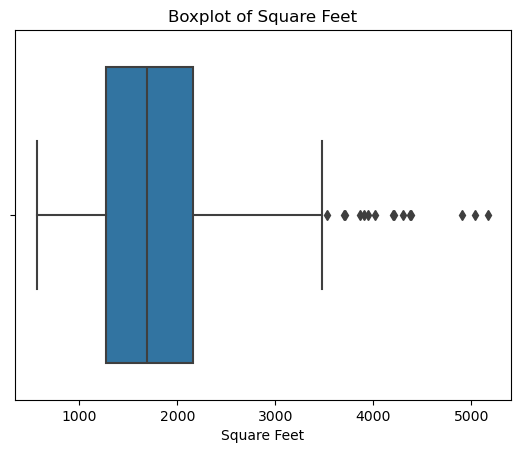

In [37]:
sns.boxplot(x=df['Square Feet'])
plt.title('Boxplot of Square Feet')
plt.show()

Observamos que disponemos de 3 viviendas con 5000 m2 (outliers).

### Análisis Estadístico  'Square Feet'

**Rango Intercuartílico (IQR)**  
El IQR es la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1). Los valores que se encuentran por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR suelen considerarse outliers.

In [38]:
# Calcular el IQR para 'Square Feet'
Q1 = df['Square Feet'].quantile(0.25)
Q3 = df['Square Feet'].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers
outliers = df[(df['Square Feet'] < (Q1 - 1.5 * IQR)) | (df['Square Feet'] > (Q3 + 1.5 * IQR))]
print(f"Número de outliers en 'Square Feet' según el Rango Intercuartílico: {len(outliers)}")

Número de outliers en 'Square Feet' según el Rango Intercuartílico: 15


### Boxplot para la columna 'Beds'

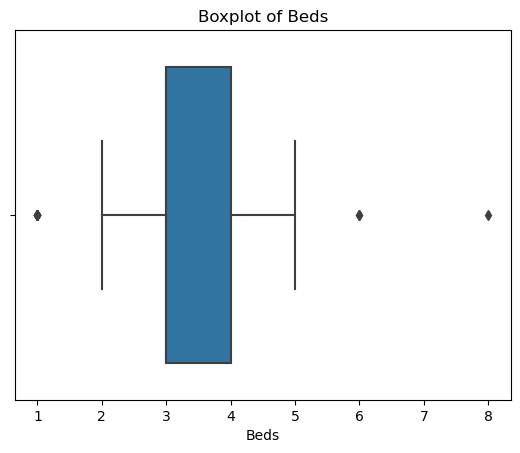

In [39]:
sns.boxplot(x=df['Beds'])
plt.title('Boxplot of Beds')
plt.show()

En el caso de las habitaciones 'Beds' observamos que tenemos 3 viviendas (outliers) una con 1 habitación, otra con 6 y otra con 8.

### Boxplot para la columna 'Baths'

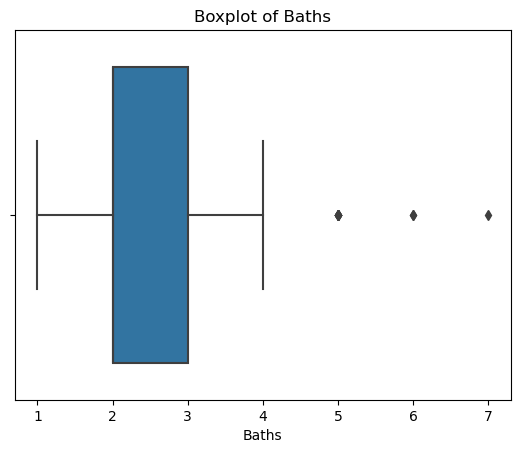

In [40]:
sns.boxplot(x=df['Baths'])
plt.title('Boxplot of Baths')
plt.show()

Y en el caso de baños también tenemos 3 viviendas (outliers) con más de 5 baños, 6 y 7. 

### Paso 1: Identificar Outliers
Primero, identificaremos los outliers en cada una de las columnas basándome en lo observado en los boxplots:

In [41]:
# Outliers en 'Square Feet'
outliers_square_feet = df[df['Square Feet'] == 5000]

# Outliers en 'Beds'
outliers_beds = df[df['Beds'].isin([1, 6, 8])]

# Outliers en 'Baths'
outliers_baths = df[df['Baths'] > 5]  # Esto captura viviendas con más de 5 baños, incluyendo 6 y 7

### Paso 2: Comprobar Coincidencias
Para comprobar si los outliers coinciden en los tres casos, vamos a utilizar los índices de los DataFrames filtrados. El objetivo es encontrar índices que estén presentes en los tres conjuntos de outliers:

In [42]:
# Intersección de índices
indices_square_feet = set(outliers_square_feet.index)
indices_beds = set(outliers_beds.index)
indices_baths = set(outliers_baths.index)

# Encuentra la intersección de los índices para ver si coinciden los mismos outliers
coincident_outliers_indices = indices_square_feet.intersection(indices_beds).intersection(indices_baths)

# Verificar si hay coincidencias
if coincident_outliers_indices:
    print(f"Índices de viviendas que son outliers en las tres categorías: {coincident_outliers_indices}")
    # Opcional: Mostrar las viviendas que coinciden
    coincident_outliers = df.loc[coincident_outliers_indices]
    print(coincident_outliers)
else:
    print("No hay viviendas que sean outliers en las tres categorías simultáneamente.")


No hay viviendas que sean outliers en las tres categorías simultáneamente.


In [43]:
df

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,Sold Date
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,San Francisco,94115,0,2024-02-16
1,1850000.0,3,2,2181.0,114 10th Ave,San Francisco,94118,0,2024-02-16
2,1450000.0,3,2,1150.0,1982 44th Ave,San Francisco,94116,0,2024-02-16
3,1310000.0,2,1,1012.0,2731 41st Ave,San Francisco,94116,0,2024-02-16
4,1360000.0,2,2,1132.0,216 Dorland St,San Francisco,94114,0,2024-02-16
...,...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2232 Daladier Dr,Rancho Palos Verdes,90275,0,2024-02-16
320,1550000.0,4,3,2390.0,27989 Beechgate Dr,Rancho Palos Verdes,90275,0,2024-02-16
321,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,La Mirada,90638,0,2024-02-16
322,745000.0,2,2,1479.0,14348 Flomar Dr,Whittier,90603,0,2024-02-16


## Análisis descriptivo y visual de los datos

In [44]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Price,324.0,1094866.29321,4100.0,580000.0,822500.0,1410000.0,8140000.0,910355.043695
Beds,324.0,3.194444,1.0,3.0,3.0,4.0,8.0,0.971338
Baths,324.0,2.466049,1.0,2.0,2.0,3.0,7.0,0.925434
Square Feet,324.0,1844.691358,572.0,1275.75,1689.0,2156.25,5173.0,804.611048
Toilets,324.0,0.003086,0.0,0.0,0.0,0.0,1.0,0.055556
Sold Date,324,2024-02-16 00:00:00,2024-02-16 00:00:00,2024-02-16 00:00:00,2024-02-16 00:00:00,2024-02-16 00:00:00,2024-02-16 00:00:00,NaN


## Visualización de Distribuciones

### Histograma de 'Price'

c:\Users\vsanc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


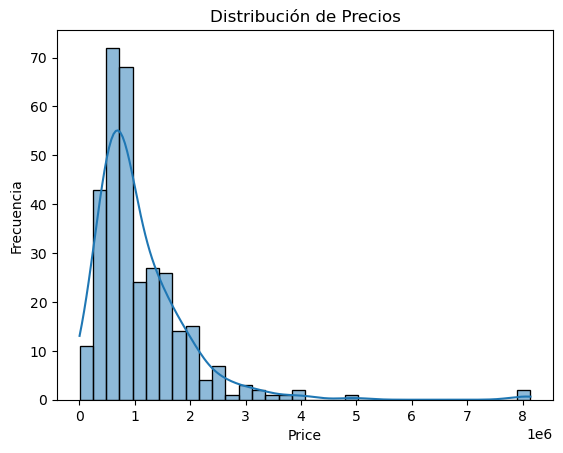

In [45]:
sns.histplot(df['Price'], kde=True)
plt.title('Distribución de Precios')
plt.xlabel('Price')
plt.ylabel('Frecuencia')
plt.show()

## Análisis de Relaciones

### Scatter Plots - relación entre 'Square Feet' y 'Price' 

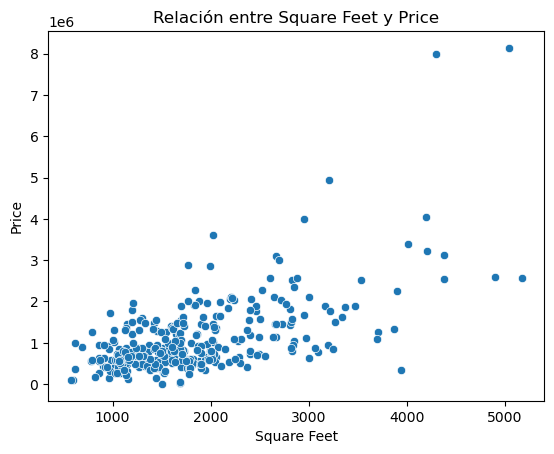

In [46]:
# Relación entre 'Square Feet' y 'Price'
sns.scatterplot(x='Square Feet', y='Price', data=df)
plt.title('Relación entre Square Feet y Price')
plt.show()

En el gráfico podemos observar que el 'groso' entre los 1000 m2 y 2000m2

### Scatter Plots - relación entre 'Square Feet' y 'Price' según las TOP 10 'City'

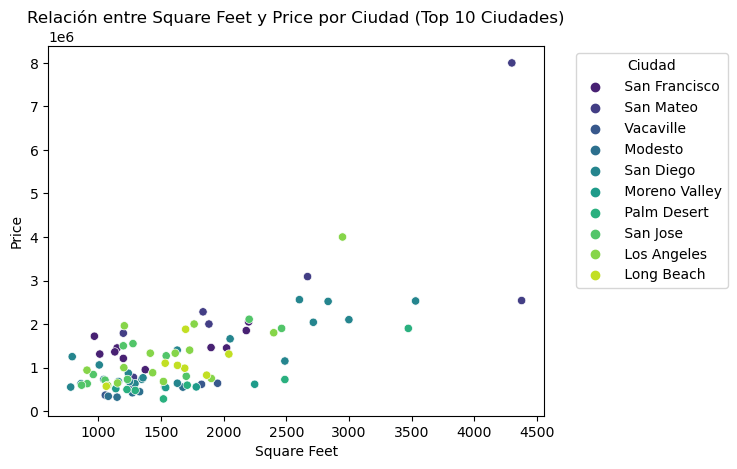

In [47]:
# Primero, identificamos las 10 ciudades con más viviendas vendidas
top_cities = df['City'].value_counts().head(10).index

# Filtramos el DataFrame para incluir solo esas ciudades
df_top_cities = df[df['City'].isin(top_cities)]

# Ahora, creamos el scatter plot para las viviendas en estas ciudades
sns.scatterplot(x='Square Feet', y='Price', hue='City', data=df_top_cities, palette='viridis')
plt.title('Relación entre Square Feet y Price por Ciudad (Top 10 Ciudades)')
plt.xlabel('Square Feet')
plt.ylabel('Price')
plt.legend(title='Ciudad', bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajusta la leyenda fuera del gráfico
plt.show()

In [48]:
top_cities

Index([' San Diego', ' Los Angeles', ' San Jose', ' San Francisco',
       ' San Mateo', ' Long Beach', ' Palm Desert', ' Vacaville', ' Modesto',
       ' Moreno Valley'],
      dtype='object', name='City')

He filtrado por las TOP 10 ciudades con más ventas de California (recordemos que es una pequeña muestra de 324 viviendas vendidas de un día en concreto 16/02/24). Observamos que existen dos "outliers" por el color identifico que son viviendas en San Mateo que tienen más de 4000m2, el resto se concentra en el mismo rango que en la gráfica anterior.

¿¿Codificación de Variables Categóricas??
Para convertir variables categóricas (como 'City''Street', ) en un formato numérico **SI ANTES DE MODELAR**

# EDA - RDC_Inventory_Core_Metrics_County

Este dataset es obtenido a través de la web de realtor, tiene datos de mercado (de California) que nos pueden ayudar a completar nuestro análisis.

### 1. Cargamos el dataset

In [49]:
df_realtor = pd.read_csv('RDC_Inventory_Core_Metrics_County.csv', encoding='utf-8', sep=',')

In [50]:
df_realtor.head()

,month_date_yyyymm,county_fips,county_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag
0,202401,46123,"tripp, sd",257500.0,0.0510,0.0300,4.0,-0.2000,-0.6190,110.0,...,4516288.0,0.2389,1.4495,6.0,0.0000,-0.4783,0.5000,0.3000,0.4048,1.0
1,202401,08057,"jackson, co",718750.0,0.3690,0.0636,6.0,-0.1429,2.0000,145.0,...,1560357.0,0.0740,1.3091,7.0,-0.0714,0.6250,0.1667,0.0238,-0.8333,1.0
2,202401,47117,"marshall, tn",370875.0,-0.0084,0.1154,116.0,-0.1145,-0.0128,74.0,...,507072.0,-0.0038,0.0459,139.0,-0.1146,-0.0211,0.1940,-0.0121,-0.0528,0.0
3,202401,05143,"washington, ar",398468.0,0.0088,-0.0123,569.0,-0.0741,0.1071,76.0,...,522550.0,0.0082,-0.0180,931.0,-0.0553,0.0065,0.6482,0.0391,-0.1541,0.0
4,202401,27159,"wadena, mn",237425.0,-0.0103,0.0731,38.0,-0.1163,0.5200,103.0,...,277465.0,0.0001,0.1770,52.0,-0.0714,0.4444,0.3816,0.0560,-0.0584,1.0


In [51]:
df_realtor.tail()

,month_date_yyyymm,county_fips,county_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag
3109,202401,30069,"petroleum, mt",310000.0,0.0000,-0.1842,6.0,0.0,1.0,124.0,...,399871.0,0.2406,0.0523,8.0,0.2500,1.5,0.2500,NaN,NaN,1.0
3110,202401,05073,"lafayette, ar",272625.0,0.5534,1.0614,11.0,0.0,4.5,138.0,...,372028.0,0.0865,1.8131,12.0,0.0909,5.0,0.0909,NaN,NaN,1.0
3111,202401,02180,"nome, ak",257500.0,-0.0077,-0.5522,2.0,-0.5,1.0,110.0,...,257500.0,-0.0039,-0.5522,2.0,-0.5000,1.0,NaN,NaN,NaN,1.0
3112,202401,02164,"lake and peninsula, ak",300000.0,0.0000,-0.0769,4.0,0.0,3.0,274.0,...,1066000.0,-0.0231,2.2800,4.0,0.0000,3.0,NaN,NaN,NaN,1.0
3113,quality_flag = 1: year-over-year figures may ...,please contact economics@realtor.com for more...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_realtor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   month_date_yyyymm                        3114 non-null   object 
 1   county_fips                              3114 non-null   object 
 2   county_name                              3113 non-null   object 
 3   median_listing_price                     3113 non-null   float64
 4   median_listing_price_mm                  3109 non-null   float64
 5   median_listing_price_yy                  3093 non-null   float64
 6   active_listing_count                     3113 non-null   float64
 7   active_listing_count_mm                  3109 non-null   float64
 8   active_listing_count_yy                  3092 non-null   float64
 9   median_days_on_market                    3113 non-null   float64
 10  median_days_on_market_mm                 3109 no

In [53]:
df_realtor.shape

(3114, 40)

In [54]:
df_realtor.nunique()

month_date_yyyymm                             2
county_fips                                3114
county_name                                3113
median_listing_price                       2379
median_listing_price_mm                    1639
median_listing_price_yy                    2467
active_listing_count                        642
active_listing_count_mm                    1437
active_listing_count_yy                    2118
median_days_on_market                       189
median_days_on_market_mm                   2161
median_days_on_market_yy                   2526
new_listing_count                           311
new_listing_count_mm                        635
new_listing_count_yy                        796
price_increased_count                        71
price_increased_count_mm                    141
price_increased_count_yy                    209
price_reduced_count                         230
price_reduced_count_mm                      504
price_reduced_count_yy                  

In [55]:
df_realtor['county_name'].unique()

array(['tripp, sd', 'jackson, co', 'marshall, tn', ..., 'nome, ak',
       'lake and peninsula, ak', nan], dtype=object)

In [56]:
df_realtor['county_name'].value_counts()

county_name
tripp, sd                 1
bibb, al                  1
crook, or                 1
crane, tx                 1
la salle, tx              1
                         ..
hockley, tx               1
walton, fl                1
bourbon, ky               1
allamakee, ia             1
lake and peninsula, ak    1
Name: count, Length: 3113, dtype: int64

In [57]:
df_realtor['county_fips'].unique()

array(['46123', '08057', '47117', ..., '02180', '02164',
       ' please contact economics@realtor.com for more details.'],
      dtype=object)

Convertimos la columna 'month_date_yyyymm' en formato fecha.

In [58]:
mask = df_realtor['month_date_yyyymm'].str.match(r'^\d{6}$')
df_realtor.loc[mask, 'month_date_yyyymm'] = pd.to_datetime(df_realtor.loc[mask, 'month_date_yyyymm'], format='%Y%m', errors='raise')



In [59]:
df_realtor['month_date_yyyymm'].head()

0    2024-01-01 00:00:00
1    2024-01-01 00:00:00
2    2024-01-01 00:00:00
3    2024-01-01 00:00:00
4    2024-01-01 00:00:00
Name: month_date_yyyymm, dtype: object

In [60]:
print(df_realtor['month_date_yyyymm'].tail())

3109                                  2024-01-01 00:00:00
3110                                  2024-01-01 00:00:00
3111                                  2024-01-01 00:00:00
3112                                  2024-01-01 00:00:00
3113    quality_flag = 1:  year-over-year figures may ...
Name: month_date_yyyymm, dtype: object


Para que sea más fácil realizar el merge() vamos a convertir la columna 'month_date_yyyymm' en formato 'YYYYMM'.

In [61]:
df_realtor['month_date_yyyymm'] = pd.to_datetime(df_realtor['month_date_yyyymm'], format='%Y%m', errors='coerce')


In [62]:
# Si 'month_date_yyyymm' ya está en el formato 'YYYYMM' como string, puedes directamente asignar esta columna a 'year_month'
df_realtor['year_month'] = df_realtor['month_date_yyyymm'].dt.strftime('%Y%m')


In [63]:
df_realtor['year_month'].head()

0    202401
1    202401
2    202401
3    202401
4    202401
Name: year_month, dtype: object

## Comprobación antes de merge df y df_realtor

Vamos a comprobar si podemos utilizar los códigos postales (ZIPS) para hacer merge() con ambos datasets.

In [64]:
df['is_in_county_fips'] = df['Zip'].apply(lambda x: x in df_realtor['county_fips'].values)

In [65]:
df['is_in_county_fips'].value_counts()

is_in_county_fips
False    324
Name: count, dtype: int64

Comprobamos que NO podemos utilizar la columna Zip para unir datos, por que son los códigos postales de los condados. Vamos a realizar el mismo procedimiento con df_realtor county name y df City.

In [66]:
df['is_in_county_name'] = df['City'].apply(lambda x: x in df_realtor['county_name'].values)

In [67]:
df['is_in_county_name'].value_counts()

is_in_county_name
False    324
Name: count, dtype: int64

In [68]:
# Mostrar los primeros 5 registros
df_realtor['county_name'].head()

0         tripp, sd
1       jackson, co
2      marshall, tn
3    washington, ar
4        wadena, mn
Name: county_name, dtype: object

In [69]:
# Mostrar los últimos 5 registros
df_realtor['county_name'].tail()

3109             petroleum, mt
3110             lafayette, ar
3111                  nome, ak
3112    lake and peninsula, ak
3113                       NaN
Name: county_name, dtype: object

Tampoco podemos unir los datasets por ciudad, porque el dataset df_realtor la columna 'county_name' con condados y no ciudades como tenemos en el df en la columna 'City'.

## Dataset df_California

La solución que he encontrado es, unir el dataset df_california_counties por ciudad con el dataset df, y después unir con county el dataset df_realtor.

In [70]:
df_california_counties = pd.read_csv('California_Incorporated_Cities.csv', encoding='utf-8', sep=',')

In [71]:
df_california_counties.head()

,OBJECTID,COUNTY,CITY,SHAPE_Length,SHAPE_Area
0,1,San Bernardino,Adelanto,122818.299737,2.025272e+08
1,2,Los Angeles,Agoura Hills,29626.940921,2.964318e+07
2,3,Alameda,Alameda,52137.889835,4.358306e+07
3,4,Alameda,Albany,16774.008108,7.558117e+06
4,5,Los Angeles,Alhambra,25461.487721,2.888338e+07


Tenemos un dato muy interesante en este dataframe, y es la longitud y el area de las ciudades. Esto nos puede ser util para nuestro análisis.

In [72]:
df_california_counties.tail()

,OBJECTID,COUNTY,CITY,SHAPE_Length,SHAPE_Area
477,478,Napa,Yountville,18166.776841,6.139924e+06
478,479,Siskiyou,Yreka,64683.192266,4.679887e+07
479,480,Sutter,Yuba City,81828.890218,7.179112e+07
480,481,San Bernardino,Yucaipa,66660.773415,1.068584e+08
481,482,San Bernardino,Yucca Valley,63739.236394,1.509317e+08


Eliminamos la columna OBJECTID

In [73]:
df_california_counties = df_california_counties.drop(columns=['OBJECTID'])


In [74]:
df['City'].unique()

array([' San Francisco', ' Lodi', ' Stockton', ' Pismo Beach', ' Bradley',
       ' Paso Robles', ' Atascadero', ' Arroyo Grande', ' Morro Bay',
       ' South San Francisco', ' San Mateo', ' Redwood City',
       ' Fairfield', ' Vallejo', ' Vacaville', ' Sebastopol',
       ' Santa Rosa', ' Windsor', ' Carpinteria', ' Santa Barbara',
       ' Lompoc', ' Santa Maria', ' Weed', ' Newman', ' Modesto',
       ' Turlock', ' Yuba City', ' Santa Cruz', ' Aptos', ' Watsonville',
       ' Red Bluff', ' Mi Wuk Village', ' Groveland', ' Dinuba',
       ' Visalia', ' Porterville', ' Pixley', ' Ventura', ' Camarillo',
       ' Port Hueneme', ' Oxnard', ' Moorpark', ' Thousand Oaks',
       ' Simi Valley', ' Fallbrook', ' Oceanside', ' Bonsall',
       ' Borrego Springs', ' Carlsbad', ' Vista', ' San Marcos', ' Poway',
       ' San Diego', ' Rancho Santa Fe', ' La Jolla', ' Santee',
       ' El Cajon', ' Rialto', ' San Bernardino', ' Bloomington',
       ' Running Springs', ' Hesperia', ' Montclair

In [75]:
df_california_counties['CITY'].unique()

array(['Adelanto', 'Agoura Hills', 'Alameda', 'Albany', 'Alhambra',
       'Aliso Viejo', 'Alturas', 'Amador City', 'American Canyon',
       'Anaheim', 'Anderson', 'Angels', 'Antioch', 'Apple Valley',
       'Arcadia', 'Arcata', 'Arroyo Grande', 'Artesia', 'Arvin',
       'Atascadero', 'Atherton', 'Atwater', 'Auburn', 'Avalon', 'Avenal',
       'Azusa', 'Bakersfield', 'Baldwin Park', 'Banning', 'Barstow',
       'Beaumont', 'Bell', 'Bell Gardens', 'Bellflower', 'Belmont',
       'Belvedere', 'Benicia', 'Berkeley', 'Beverly Hills',
       'Big Bear Lake', 'Biggs', 'Bishop', 'Blue Lake', 'Blythe',
       'Bradbury', 'Brawley', 'Brea', 'Brentwood', 'Brisbane', 'Buellton',
       'Buena Park', 'Burbank', 'Burlingame', 'Calabasas', 'Calexico',
       'California', 'Calimesa', 'Calipatria', 'Calistoga', 'Camarillo',
       'Campbell', 'Canyon Lake', 'Capitola', 'Carlsbad',
       'Carmel-by-the-Sea', 'Carpinteria', 'Carson', 'Cathedral City',
       'Ceres', 'Cerritos', 'Chico', 'Chino', 'C

### Unión Dataframes df y df_california_counties Donde se cargarán los nombres de los condados, para unir el tercer dataframe df_realtor.

1. Hacemos Marge con df y df_california_countries a través de las columnas Ciudad. Pero primero vamos a  usar str.lower() para convertir a minúsculas, str.strip() para eliminar espacios en blanco adicionales, y verificar la consistencia de los datos. Así nos aseguramos de que los valores de  las columnas sean consistentes en ambos Dataframes.

In [76]:
df['City'] = df['City'].str.lower().str.strip()
df_california_counties['CITY'] = df_california_counties['CITY'].str.lower().str.strip()

Para conservar todas las filas del DataFrame de la izquierda (df) y llenar con NaN las columnas del DataFrame de la derecha (df_california_counties) paralas filas donde no haya coincidencia, utilizarmeso left join.

In [77]:
merged_df = pd.merge(df, df_california_counties, left_on='City', right_on='CITY', how='left')
# Esto realiza un left join, manteniendo solo las filas que tienen correspondencia en ambas columnas,

In [78]:
merged_df

,Price,Beds,Baths,Square Feet,Street,City,Zip,Toilets,Sold Date,is_in_county_fips,is_in_county_name,COUNTY,CITY,SHAPE_Length,SHAPE_Area
0,1720000.0,2,2,969.0,2200 Sacramento St APT 206,san francisco,94115,0,2024-02-16,False,False,San Francisco,san francisco,78294.793713,2.188028e+08
1,1850000.0,3,2,2181.0,114 10th Ave,san francisco,94118,0,2024-02-16,False,False,San Francisco,san francisco,78294.793713,2.188028e+08
2,1450000.0,3,2,1150.0,1982 44th Ave,san francisco,94116,0,2024-02-16,False,False,San Francisco,san francisco,78294.793713,2.188028e+08
3,1310000.0,2,1,1012.0,2731 41st Ave,san francisco,94116,0,2024-02-16,False,False,San Francisco,san francisco,78294.793713,2.188028e+08
4,1360000.0,2,2,1132.0,216 Dorland St,san francisco,94114,0,2024-02-16,False,False,San Francisco,san francisco,78294.793713,2.188028e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,1680000.0,4,3,2948.0,2232 Daladier Dr,rancho palos verdes,90275,0,2024-02-16,False,False,Los Angeles,rancho palos verdes,75838.372826,5.071580e+07
320,1550000.0,4,3,2390.0,27989 Beechgate Dr,rancho palos verdes,90275,0,2024-02-16,False,False,Los Angeles,rancho palos verdes,75838.372826,5.071580e+07
321,675000.0,3,2,1271.0,13218 La Jolla Cir UNIT C,la mirada,90638,0,2024-02-16,False,False,Los Angeles,la mirada,29339.414247,2.956609e+07
322,745000.0,2,2,1479.0,14348 Flomar Dr,whittier,90603,0,2024-02-16,False,False,Los Angeles,whittier,60122.342762,5.533268e+07


# EDA - df_realtor

In [100]:
df_realtor.head(10)

,month_date_yyyymm,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,year_month,county,initials
0,2024-01-01,46123,257500.0,0.0510,0.0300,4.0,-0.2000,-0.6190,110.0,0.4253,...,6.0,0.0000,-0.4783,0.5000,0.3000,0.4048,1.0,202401,tripp,sd
1,2024-01-01,08057,718750.0,0.3690,0.0636,6.0,-0.1429,2.0000,145.0,-0.0350,...,7.0,-0.0714,0.6250,0.1667,0.0238,-0.8333,1.0,202401,jackson,co
2,2024-01-01,47117,370875.0,-0.0084,0.1154,116.0,-0.1145,-0.0128,74.0,0.1308,...,139.0,-0.1146,-0.0211,0.1940,-0.0121,-0.0528,0.0,202401,marshall,tn
3,2024-01-01,05143,398468.0,0.0088,-0.0123,569.0,-0.0741,0.1071,76.0,0.1103,...,931.0,-0.0553,0.0065,0.6482,0.0391,-0.1541,0.0,202401,washington,ar
4,2024-01-01,27159,237425.0,-0.0103,0.0731,38.0,-0.1163,0.5200,103.0,0.0868,...,52.0,-0.0714,0.4444,0.3816,0.0560,-0.0584,1.0,202401,wadena,mn
5,2024-01-01,37037,850000.0,0.0000,0.0904,201.0,-0.1027,-0.1027,86.0,-0.0284,...,360.0,-0.0476,-0.1499,0.7960,0.1219,-0.0879,0.0,202401,chatham,nc
6,2024-01-01,13269,94750.0,0.2147,-0.1689,5.0,-0.1000,0.1250,112.0,0.2816,...,6.0,-0.1429,0.2000,0.2222,-0.1778,-0.1528,1.0,202401,taylor,ga
7,2024-01-01,19161,217100.0,0.1313,0.4136,26.0,-0.0556,0.3077,90.0,0.1424,...,32.0,-0.0156,-0.0308,0.2353,0.0501,-0.4314,1.0,202401,sac,ia
8,2024-01-01,13275,333675.0,-0.0038,0.1716,125.0,-0.0040,0.3037,77.0,0.0405,...,157.0,0.0000,0.2460,0.2651,-0.0149,-0.0805,0.0,202401,thomas,ga
9,2024-01-01,55029,524900.0,-0.0187,-0.2031,220.0,-0.0909,0.4426,137.0,0.1417,...,279.0,-0.0762,0.3037,0.2795,0.0233,-0.1303,1.0,202401,door,wi


In [101]:
df_realtor.tail(10)

,month_date_yyyymm,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,year_month,county,initials
3103,2024-01-01,18063,362325.0,-0.0002,0.0301,223.0,-0.1186,0.4159,59.0,0.1700,...,409.0,-0.1050,0.1084,0.8386,0.0322,-0.5170,0.0,202401,hendricks,in
3104,2024-01-01,06003,90625.0,-0.4958,0.9180,38.0,-0.1477,0.0870,145.0,0.0947,...,44.0,-0.1122,0.1013,0.1467,0.0103,0.0162,1.0,202401,alpine,ca
3105,2024-01-01,37187,180200.0,0.0239,0.1749,26.0,0.1087,0.6452,64.0,0.2800,...,31.0,0.0690,0.2917,0.2157,-0.0452,-0.3327,1.0,202401,washington,nc
3106,2024-01-01,48075,185000.0,0.0221,0.5514,12.0,-0.0417,0.4375,104.0,0.2135,...,12.0,-0.0417,0.1500,NaN,NaN,NaN,1.0,202401,childress,tx
3107,2024-01-01,30037,499900.0,0.0000,1.8879,1.0,0.0000,-0.6667,98.0,0.4773,...,1.0,0.0000,-0.6667,NaN,NaN,NaN,1.0,202401,golden valley,mt
3108,2024-01-01,20097,274999.0,0.2500,3.5910,1.0,-0.6667,0.0000,83.0,0.1458,...,2.0,-0.3333,1.0000,1.0000,NaN,0.5000,1.0,202401,kiowa,ks
3109,2024-01-01,30069,310000.0,0.0000,-0.1842,6.0,0.0000,1.0000,124.0,0.1923,...,8.0,0.2500,1.5000,0.2500,NaN,NaN,1.0,202401,petroleum,mt
3110,2024-01-01,05073,272625.0,0.5534,1.0614,11.0,0.0000,4.5000,138.0,0.2972,...,12.0,0.0909,5.0000,0.0909,NaN,NaN,1.0,202401,lafayette,ar
3111,2024-01-01,02180,257500.0,-0.0077,-0.5522,2.0,-0.5000,1.0000,110.0,-0.1852,...,2.0,-0.5000,1.0000,NaN,NaN,NaN,1.0,202401,nome,ak
3112,2024-01-01,02164,300000.0,0.0000,-0.0769,4.0,0.0000,3.0000,274.0,0.0984,...,4.0,0.0000,3.0000,NaN,NaN,NaN,1.0,202401,lake and peninsula,ak


eliminamos la última fila que no nos proporciona información

In [81]:
df_realtor = df_realtor.drop(index=3113)
df_realtor

,month_date_yyyymm,county_fips,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,year_month,county,initials
0,2024-01-01,46123,257500.0,0.0510,0.0300,4.0,-0.2000,-0.6190,110.0,0.4253,...,6.0,0.0000,-0.4783,0.5000,0.3000,0.4048,1.0,202401,tripp,sd
1,2024-01-01,08057,718750.0,0.3690,0.0636,6.0,-0.1429,2.0000,145.0,-0.0350,...,7.0,-0.0714,0.6250,0.1667,0.0238,-0.8333,1.0,202401,jackson,co
2,2024-01-01,47117,370875.0,-0.0084,0.1154,116.0,-0.1145,-0.0128,74.0,0.1308,...,139.0,-0.1146,-0.0211,0.1940,-0.0121,-0.0528,0.0,202401,marshall,tn
3,2024-01-01,05143,398468.0,0.0088,-0.0123,569.0,-0.0741,0.1071,76.0,0.1103,...,931.0,-0.0553,0.0065,0.6482,0.0391,-0.1541,0.0,202401,washington,ar
4,2024-01-01,27159,237425.0,-0.0103,0.0731,38.0,-0.1163,0.5200,103.0,0.0868,...,52.0,-0.0714,0.4444,0.3816,0.0560,-0.0584,1.0,202401,wadena,mn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,2024-01-01,20097,274999.0,0.2500,3.5910,1.0,-0.6667,0.0000,83.0,0.1458,...,2.0,-0.3333,1.0000,1.0000,NaN,0.5000,1.0,202401,kiowa,ks
3109,2024-01-01,30069,310000.0,0.0000,-0.1842,6.0,0.0000,1.0000,124.0,0.1923,...,8.0,0.2500,1.5000,0.2500,NaN,NaN,1.0,202401,petroleum,mt
3110,2024-01-01,05073,272625.0,0.5534,1.0614,11.0,0.0000,4.5000,138.0,0.2972,...,12.0,0.0909,5.0000,0.0909,NaN,NaN,1.0,202401,lafayette,ar
3111,2024-01-01,02180,257500.0,-0.0077,-0.5522,2.0,-0.5000,1.0000,110.0,-0.1852,...,2.0,-0.5000,1.0000,NaN,NaN,NaN,1.0,202401,nome,ak


Confirmamos a través de la función dtypes en qué formato está la columna de la fecha

In [82]:
df_realtor.dtypes

month_date_yyyymm                          datetime64[ns]
county_fips                                        object
median_listing_price                              float64
median_listing_price_mm                           float64
median_listing_price_yy                           float64
active_listing_count                              float64
active_listing_count_mm                           float64
active_listing_count_yy                           float64
median_days_on_market                             float64
median_days_on_market_mm                          float64
median_days_on_market_yy                          float64
new_listing_count                                 float64
new_listing_count_mm                              float64
new_listing_count_yy                              float64
price_increased_count                             float64
price_increased_count_mm                          float64
price_increased_count_yy                          float64
price_reduced_

In [83]:
df_realtor.columns

Index(['month_date_yyyymm', 'county_fips', 'median_listing_price',
       'median_listing_price_mm', 'median_listing_price_yy',
       'active_listing_count', 'active_listing_count_mm',
       'active_listing_count_yy', 'median_days_on_market',
       'median_days_on_market_mm', 'median_days_on_market_yy',
       'new_listing_count', 'new_listing_count_mm', 'new_listing_count_yy',
       'price_increased_count', 'price_increased_count_mm',
       'price_increased_count_yy', 'price_reduced_count',
       'price_reduced_count_mm', 'price_reduced_count_yy',
       'pending_listing_count', 'pending_listing_count_mm',
       'pending_listing_count_yy', 'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'total_listing_count',
       

Comprobamos que tengamos datos del mes de febrero

In [84]:
# Verificar si existen datos de febrero de 2024
february_exists = '2024-02' in df_realtor['year_month'].values
print(f"Datos de febrero de 2024 presentes: {february_exists}")


Datos de febrero de 2024 presentes: False


No tenemos datos de febrero, por lo tanto, vamos a simplificar la información. Vamos a agrupar toda la información que tenemos por condado, para este 

1. Primero vamos a eliminar las columnas que no aportan valor significativo al análisis o que podrían duplicarse tras la fusión. 

In [85]:
# Eliminar columnas seleccionadas
columns_to_drop = ['quality_flag', 'initials', 'county_fips','year_month', 'active_listing_count','active_listing_count_mm', ]
df_realtor_cleaned = df_realtor.drop(columns=columns_to_drop)

# Verificar el DataFrame resultante
print(df_realtor_cleaned.columns)


Index(['month_date_yyyymm', 'median_listing_price', 'median_listing_price_mm',
       'median_listing_price_yy', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_listing_count',
       'pending_listing_count_mm', 'pending_listing_count_yy',
       'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'total_listing_count',
       'total_listing_

A continuación vamos a comprobar los valores NaN o nulos que tiene el dataset.

In [86]:
df_realtor_cleaned.isnull().sum()

month_date_yyyymm                             0
median_listing_price                          0
median_listing_price_mm                       4
median_listing_price_yy                      20
active_listing_count                          0
active_listing_count_mm                       4
active_listing_count_yy                      21
median_days_on_market                         0
median_days_on_market_mm                      4
median_days_on_market_yy                     20
new_listing_count                             0
new_listing_count_mm                        504
new_listing_count_yy                        346
price_increased_count                         0
price_increased_count_mm                   2535
price_increased_count_yy                   2368
price_reduced_count                           0
price_reduced_count_mm                      733
price_reduced_count_yy                      541
pending_listing_count                       101
pending_listing_count_mm                

Observamos que tenemos muchas columnas con valores faltantes, antes de entrar en detalle, vamos a realizar el groupby, y luego continuamos con 
el análisis y la limpieza.

In [87]:
df_realtor_all = df_realtor_cleaned.groupby('county').agg('mean').reset_index()
df_realtor_all

,county,month_date_yyyymm,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
0,abbeville,2024-01-01,246975.0,0.05100,0.2355,46.00,-0.010900,0.281700,91.0,0.360900,...,0.035900,299976.00,-0.0028,0.06900,51.00,-0.07270,0.051500,0.15380,-0.06350,-0.22640
1,acadia,2024-01-01,187575.0,-0.01280,0.0538,77.00,-0.049400,0.193800,104.0,0.232100,...,-0.018700,349864.00,0.0010,0.40010,106.00,-0.09830,0.082100,0.37660,-0.06780,-0.15830
2,accomack,2024-01-01,324968.0,-0.00010,0.0156,159.00,0.012700,0.218400,105.0,0.131700,...,-0.160300,382443.00,-0.0151,-0.06380,206.00,0.00980,0.072900,0.29250,-0.00690,-0.19800
3,ada,2024-01-01,644920.0,0.04040,0.1465,950.00,-0.197600,-0.349100,61.0,0.129600,...,0.044200,817240.00,0.0222,0.14840,1854.00,-0.09030,-0.191500,0.95050,0.22760,0.38830
4,adair,2024-01-01,209262.5,-0.00330,0.0770,38.25,-0.076675,0.085375,107.5,0.320875,...,-0.071825,284003.25,0.0193,0.07980,48.25,-0.07840,0.021925,0.31285,-0.00105,-0.07135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,yuba,2024-01-01,466197.0,0.02820,-0.0065,142.00,-0.098700,-0.222500,64.0,0.254900,...,-0.019100,470693.00,0.0113,-0.09930,258.00,-0.06360,0.025900,0.84100,0.12120,0.45640
1828,yukon-koyukuk,2024-01-01,375000.0,0.15380,1.3438,12.00,0.000000,3.800000,150.0,0.197200,...,0.029200,402075.00,0.0300,1.36510,12.00,0.00000,3.800000,NaN,NaN,NaN
1829,yuma,2024-01-01,317362.5,0.01675,0.1665,215.50,-0.005200,0.093600,68.5,-0.103700,...,0.039750,390458.50,-0.0143,0.27015,279.00,-0.00095,0.084100,0.24150,0.02120,-0.01570
1830,zapata,2024-01-01,167500.0,0.07720,-0.0642,32.00,0.000000,0.207500,111.0,-0.079200,...,-0.016000,180937.00,0.0252,-0.10140,32.00,0.00000,0.207500,NaN,NaN,NaN


In [88]:
df_realtor_all.columns

Index(['county', 'month_date_yyyymm', 'median_listing_price',
       'median_listing_price_mm', 'median_listing_price_yy',
       'active_listing_count', 'active_listing_count_mm',
       'active_listing_count_yy', 'median_days_on_market',
       'median_days_on_market_mm', 'median_days_on_market_yy',
       'new_listing_count', 'new_listing_count_mm', 'new_listing_count_yy',
       'price_increased_count', 'price_increased_count_mm',
       'price_increased_count_yy', 'price_reduced_count',
       'price_reduced_count_mm', 'price_reduced_count_yy',
       'pending_listing_count', 'pending_listing_count_mm',
       'pending_listing_count_yy', 'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'total_listing_count',
       'tota

Comprbamos que solo tenemos datos del mes de enero. Por lo tanto la columna month_date_yyyymm podemos eliminarla.

In [89]:
df_realtor_all['month_date_yyyymm'].unique

<bound method Series.unique of 0      2024-01-01
1      2024-01-01
2      2024-01-01
3      2024-01-01
4      2024-01-01
          ...    
1827   2024-01-01
1828   2024-01-01
1829   2024-01-01
1830   2024-01-01
1831   2024-01-01
Name: month_date_yyyymm, Length: 1832, dtype: datetime64[ns]>

In [90]:
df_realtor_all.drop('month_date_yyyymm', axis=1, inplace=True)
df_realtor_all

,county,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,median_days_on_market_mm,median_days_on_market_yy,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
0,abbeville,246975.0,0.05100,0.2355,46.00,-0.010900,0.281700,91.0,0.360900,0.049300,...,0.035900,299976.00,-0.0028,0.06900,51.00,-0.07270,0.051500,0.15380,-0.06350,-0.22640
1,acadia,187575.0,-0.01280,0.0538,77.00,-0.049400,0.193800,104.0,0.232100,0.069800,...,-0.018700,349864.00,0.0010,0.40010,106.00,-0.09830,0.082100,0.37660,-0.06780,-0.15830
2,accomack,324968.0,-0.00010,0.0156,159.00,0.012700,0.218400,105.0,0.131700,0.016900,...,-0.160300,382443.00,-0.0151,-0.06380,206.00,0.00980,0.072900,0.29250,-0.00690,-0.19800
3,ada,644920.0,0.04040,0.1465,950.00,-0.197600,-0.349100,61.0,0.129600,-0.237500,...,0.044200,817240.00,0.0222,0.14840,1854.00,-0.09030,-0.191500,0.95050,0.22760,0.38830
4,adair,209262.5,-0.00330,0.0770,38.25,-0.076675,0.085375,107.5,0.320875,0.229925,...,-0.071825,284003.25,0.0193,0.07980,48.25,-0.07840,0.021925,0.31285,-0.00105,-0.07135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,yuba,466197.0,0.02820,-0.0065,142.00,-0.098700,-0.222500,64.0,0.254900,-0.209900,...,-0.019100,470693.00,0.0113,-0.09930,258.00,-0.06360,0.025900,0.84100,0.12120,0.45640
1828,yukon-koyukuk,375000.0,0.15380,1.3438,12.00,0.000000,3.800000,150.0,0.197200,-0.046000,...,0.029200,402075.00,0.0300,1.36510,12.00,0.00000,3.800000,NaN,NaN,NaN
1829,yuma,317362.5,0.01675,0.1665,215.50,-0.005200,0.093600,68.5,-0.103700,-0.071900,...,0.039750,390458.50,-0.0143,0.27015,279.00,-0.00095,0.084100,0.24150,0.02120,-0.01570
1830,zapata,167500.0,0.07720,-0.0642,32.00,0.000000,0.207500,111.0,-0.079200,-0.221800,...,-0.016000,180937.00,0.0252,-0.10140,32.00,0.00000,0.207500,NaN,NaN,NaN


### Unión Dataframes df_realtor y merge_df a través de los nombres de los condados.

### 1. Normalizar los nombres de los condados.

Primero vamos a normalizar los nombres de los condados para asegurarnos de que coincidan.

In [97]:
merged_df['COUNTY_normalized'] = merged_df['COUNTY'].str.lower().str.strip()

### 2. Agrupar y unir los DataFrames

In [98]:
df_realtor_all['county_normalized'] = df_realtor_all['county'].str.lower().str.strip()